# Extract

In [2]:
import gzip             #importo la librería para leer los archivos gzip, formato de compresion en el que vinieron los archivos
import pandas as pd     #importo librería pandas que vamos a usar para el data frame
import ast              #importo librería ast que me ayuda a leer la gramatica abstracta

### Steamgames

In [3]:
#si bien se podría descomprimir el archivo y directamente leerlo de pandas, dado que futuras actualziaciones pueden venir como gzip, es preferible trabajarlos desde ese formato
with gzip.open('Datos_sin_procesar/steam_games.json.gz', 'rb') as f:
    df_steamgames=pd.read_json(f, lines=True)

### User Items

In [4]:
#comienzo con una lista para poder insertar cada línea del archivo
data=[]
with gzip.open('Datos_sin_procesar/users_items.json.gz', 'rb') as f:
    for line in f:
        #cargar la información usando ast, porque si se usa json se dan errores por sintacis de gramatica en el uso de comillas
        data.append(ast.literal_eval(line.decode('utf-8')))

# Convierto la lista a DataFrame
df_users_items = pd.DataFrame(data)

### User Reviews

In [5]:
#comienzo con una lista para poder insertar cada línea del archivo
data=[]
with gzip.open('Datos_sin_procesar/user_reviews.json.gz', 'rb') as f:
    for line in f:
        #cargar la información usando ast, porque si se usa json se dan errores por sintacis de gramatica en el uso de comillas
        data.append(ast.literal_eval(line.decode('utf-8')))

# Convierto la lista a DataFrame
df_user_reviews = pd.DataFrame(data)

In [ ]:
df_user_reviews

# Transorm

### Steamgames

In [6]:
#elimino los valores con todos nulos
df_steamgames.dropna(inplace= True, how='all')

In [7]:
#verificamos algún id que esté nulo.
df_steamgames[df_steamgames['id'].isnull()]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
88384,None,None,None,None,http://store.steampowered.com/,None,None,None,None,19.99,0.0,NaN,None
119271,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",None,"[Single-player, Steam Achievements, Steam Trad...",19.99,0.0,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


In [8]:
#se verifica sin con la url podemos obetener el id del juego
df_steamgames[['url','id']]
#se concluye que sí, y se pasa a asignar ese valor a los faltantes

,url,id
88310,http://store.steampowered.com/app/761140/Lost_...,761140.0
88311,http://store.steampowered.com/app/643980/Ironb...,643980.0
88312,http://store.steampowered.com/app/670290/Real_...,670290.0
88313,http://store.steampowered.com/app/767400/2222/,767400.0
88314,http://store.steampowered.com/app/773570/Log_C...,773570.0
...,...,...
120440,http://store.steampowered.com/app/773640/Colon...,773640.0
120441,http://store.steampowered.com/app/733530/LOGis...,733530.0
120442,http://store.steampowered.com/app/610660/Russi...,610660.0
120443,http://store.steampowered.com/app/658870/EXIT_...,658870.0


In [9]:
#se importa la libreria re para poder trabajar sobre la extracción del ID de la url, y se genera una función para este propósito
import re

def extraer_numero_url(url):
    if url is None:
        return None
    else:
        match = re.search(r'(\d+)', url)
        if match:
            return match.group(1)
        else:
            return None

#aplicamos la funcion a una columna auxiliar
df_steamgames['id_aux']=df_steamgames['url'].apply(extraer_numero_url)
#aplicamos la columna auxiliar a los valores nulos
df_steamgames['id'][df_steamgames['id'].isnull()]=df_steamgames['id_aux']
#eliminamos los id nulos
df_steamgames.dropna(subset=['id'], inplace=True)
#eliminamos la columna auxiliar
df_steamgames.drop(columns=['id_aux'], inplace=True)


C:\Users\feder\AppData\Local\Temp\ipykernel_12140\4277996820.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_steamgames['id'][df_steamgames['id'].isnull()]=df_steamgames['id_aux']
C:\Users\feder\AppData\Local\Temp\ipykernel_12140\427

La columna genres tiene listas con los generos a los que puede pertenecer el juego. Para un mejor procesamiento a posteriori de los datos, se transforma esa columna en varias columnas dummies con cada uno de esos valores.
También se tiene la columna tags, pero que tiene muchos más valores. Algunos de ellos son las categorías, y también otros tipos de etiquetas. Se arma un dataframe para rellenar los valores faltantes de etiquetas.

In [15]:
#primero llenamos los nulos con valor [], para su posterior procesamiento

# Define una función para reemplazar los valores nulos con una lista vacía
def reemplazonulo(lst):
    return lst if isinstance(lst, list) else []

# Aplica la función a la columna con listas
df_steamgames['genres'] = df_steamgames['genres'].apply(reemplazonulo)
df_steamgames['tags'] = df_steamgames['tags'].apply(reemplazonulo)

In [16]:
df_steamgames['genres'].describe()

count     32134
unique      884
top          []
freq       3282
Name: genres, dtype: object

In [17]:
#Separo la columna de generos
df_genres = df_steamgames['genres'].apply(lambda x: pd.Series({val: 1 for val in x}))
#lleno los nulos con 0
df_genres.fillna(0, inplace=True)
#Se renombran columnas que tienen mal los nombres
df_genres.rename(columns={'Design &amp; Illustration':'Design & Illustration','Animation &amp; Modeling':'Animation & Modeling'}, inplace= True)
#armo una lista con los generos
list_Genres=df_genres.columns.to_list()


In [18]:
list_Genres

['Action',
 'Casual',
 'Indie',
 'Simulation',
 'Strategy',
 'Free to Play',
 'RPG',
 'Sports',
 'Adventure',
 'Racing',
 'Early Access',
 'Massively Multiplayer',
 'Animation & Modeling',
 'Video Production',
 'Utilities',
 'Web Publishing',
 'Education',
 'Software Training',
 'Design & Illustration',
 'Audio Production',
 'Photo Editing',
 'Accounting']

In [19]:
#Se genera el dataframe de de tags
df_tags = df_steamgames['tags'].apply(lambda x: pd.Series({val: 1 for val in x}))
df_tags.fillna(0, inplace=True)
#idem caso anterior con nombres mal importados
df_tags.rename(columns={'Design &amp; Illustration':'Design & Illustration','Animation &amp; Modeling':'Animation & Modeling'}, inplace= True)

In [20]:
#verificamos que todos los géneros están en la lista
tags=df_tags.columns.tolist()
genres=df_genres.columns.tolist()
for i in genres:
    if i in tags: print(i+' está')
    else:
        print(i+'no está')

Action está
Casual está
Indie está
Simulation está
Strategy está
Free to Play está
RPG está
Sports está
Adventure está
Racing está
Early Access está
Massively Multiplayer está
Animation & Modeling está
Video Production está
Utilities está
Web Publishing está
Education está
Software Training está
Design & Illustration está
Audio Production está
Photo Editing está
Accountingno está


In [21]:
#sacamos el genero Accounting que no se encuentra en ningún tag
genres.remove('Accounting')

#completamos las categorías que son nulas en la columna de categoria pero si fueron etiquetadas usando los tags
for i in genres:
    for index, row in df_genres.iterrows():
        if row[i] == 0:
            df_genres.at[index, i] = df_tags.at[index, i]
df_steamgames=pd.concat([df_steamgames,df_genres], axis=1)

#eliminamos la columna genres, que tiene las listas de géneros
df_steamgames.drop('genres', axis=1,inplace= True)

#eliminamos los dataframes que ya no usamos
del df_genres
del df_tags

#volvemos a agregar el genero Accounting
genres.append('Accounting')

In [22]:
df_steamgames['release_date'] = pd.to_datetime(df_steamgames['release_date'], errors='coerce')
df_steamgames.loc[~df_steamgames['release_date'].notnull(), 'release_date'] = None
df_steamgames['release_year'] = df_steamgames['release_date'].dt.year

In [23]:
df_steamgames['release_year'] = df_steamgames['release_year'].fillna(0)
df_steamgames['release_year'] = df_steamgames['release_year'].astype(int)
for i in genres:
    df_steamgames[i] = df_steamgames[i].fillna(0)
    df_steamgames[i] = df_steamgames[i].astype(int)
df_steamgames['Accounting'] = df_steamgames['Accounting'].astype(int)

In [25]:
df_steamgames['id']=df_steamgames['id'].astype(int)

In [27]:
df_steamgames.drop(['publisher','app_name','title','url','release_date','tags','reviews_url','specs','price','early_access',
                                 'developer'],axis=1,inplace=True)

In [56]:
df_steamgames = df_steamgames.rename(columns={'id': 'item_id'})

In [80]:
df_steamgames['Action'][1241]

0

In [73]:
df_steamgames.describe()

,item_id,Action,Casual,Indie,Simulation,Strategy,Free to Play,RPG,Sports,Adventure,...,Utilities,Web Publishing,Education,Software Training,Design & Illustration,Audio Production,Photo Editing,Accounting,release_year,playtime_forever
count,3.213400e+04,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,...,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,9.193000e+03
mean,4.517496e+05,0.405116,0.303946,0.549014,0.241146,0.235763,0.075092,0.184509,0.049791,0.306280,...,0.019076,0.008745,0.011701,0.004014,0.019574,0.003734,0.002490,0.000218,1867.354578,4.921556e+05
std,1.827166e+05,0.490922,0.459967,0.497600,0.427786,0.424481,0.263544,0.387904,0.217517,0.460955,...,0.136796,0.093104,0.107538,0.063233,0.138534,0.060996,0.049834,0.014758,524.668077,1.015944e+07
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,3.292725e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,3.680000e+02
50%,4.520300e+05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.000000,4.122000e+03
75%,5.933975e+05,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,2.252300e+04
max,2.028850e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2021.000000,7.851843e+08


### User Items

Se posee en la columna items listas con diccionarios. Cada diccionario tiene 4 atributos. Se genera una fila para cada diccionario, y 4 columnas posteriores a partir del diccionario

In [28]:
#primero se inserta una fila por cada diccionario de la columna item
df_users_items=df_users_items.explode('items')
df_users_items = df_users_items.reset_index(drop=True)

In [33]:
#luego se arma un dataframe nuevo a partir de los diccionarios de item, con una columna por cada atributo
# el metodo normal sería este, pero tarda mucho, con lo cual buscamos extraer columna por columna df_users_items_items=df_users_items['items'].apply(pd.Series)

In [32]:
def obtener_elemento(diccionario, clave_busqueda):
    if isinstance(diccionario, dict):
        return diccionario.get(clave_busqueda)
    else:
        return diccionario

df_users_items['item_id'] = df_users_items['items'].apply(lambda x: obtener_elemento(x, 'item_id'))
df_users_items['item_name'] = df_users_items['items'].apply(lambda x: obtener_elemento(x, 'item_name'))
df_users_items['playtime_forever'] = df_users_items['items'].apply(lambda x: obtener_elemento(x, 'playtime_forever'))
df_users_items['playtime_2weeks'] = df_users_items['items'].apply(lambda x: obtener_elemento(x, 'playtime_2weeks'))

In [35]:
#Saco la columna items que ya no es util
df_users_items.drop('items', axis=1,inplace= True)
#eliminamos las filas que no tienen valor de juego
df_users_items = df_users_items.dropna(subset=['item_id', 'item_name'], how='all')

### User Reviews

Cada objeto de la columna review es una lista que tiene varios valores de diccionario, de 7 atributos 'funny', 'posted',   'last_edited', 'item_id', 'helpful', 'recommend', 'review'. Se debe transformar cada diccionario en una fila, y cada uno de estos 7 atriburos en una columna, de manera tal que el dataframe refleje la realidad de datos que tenemos

In [36]:
#paso cada lista a una fila, aplicando metodo explode
df_user_reviews=df_user_reviews.explode('reviews')
#paso cada atributo del diccionario a una columna nueva, aplicando metodo apply
df_user_reviews_exp=df_user_reviews['reviews'].apply(pd.Series)

In [38]:
#junto el dataframe original y las nuevas columnas
df_user_reviews=pd.concat([df_user_reviews, df_user_reviews_exp], axis=1)
#elimino la columna original
df_user_reviews.drop(['reviews','user_url', 'funny', 'last_edited', 
                      'helpful', 0], axis=1, inplace=True)

In [41]:
from textblob import TextBlob
df_user_reviews['review'] = df_user_reviews['review'].astype(str)
df_user_reviews['polarity'] = df_user_reviews['review'].apply(lambda text: TextBlob(text).sentiment.polarity)


In [43]:
import matplotlib.pyplot as plt

(array([1.9600e+02, 1.3000e+01, 0.0000e+00, 0.0000e+00, 5.0000e+00,
        9.0000e+00, 9.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        9.4000e+01, 4.0000e+00, 7.0000e+01, 4.0000e+00, 2.6000e+01,
        1.6700e+02, 1.3000e+01, 2.0000e+01, 5.1000e+01, 4.7000e+01,
        8.3000e+01, 2.4000e+01, 7.8000e+01, 2.6000e+01, 3.7000e+01,
        3.4000e+02, 3.0000e+01, 9.2000e+01, 6.4000e+01, 6.5000e+01,
        1.7440e+03, 1.1900e+02, 1.7200e+02, 1.4100e+02, 2.9300e+02,
        1.4900e+02, 1.9900e+02, 3.0900e+02, 2.4000e+02, 8.0400e+02,
        2.5500e+02, 3.8300e+02, 5.5200e+02, 6.2700e+02, 8.5200e+02,
        5.6100e+02, 8.2200e+02, 1.0020e+03, 1.0370e+03, 9.1300e+02,
        1.4095e+04, 1.2080e+03, 1.7440e+03, 1.4290e+03, 2.0370e+03,
        1.2460e+03, 1.4540e+03, 1.9410e+03, 1.4050e+03, 9.8100e+02,
        2.2860e+03, 1.0500e+03, 1.3440e+03, 9.2800e+02, 2.4650e+03,
        5.7000e+02, 6.7200e+02, 7.0000e+02, 6.3500e+02, 8.4000e+02,
        2.6600e+02, 3.6100e+02, 2.6700e+02, 3.61

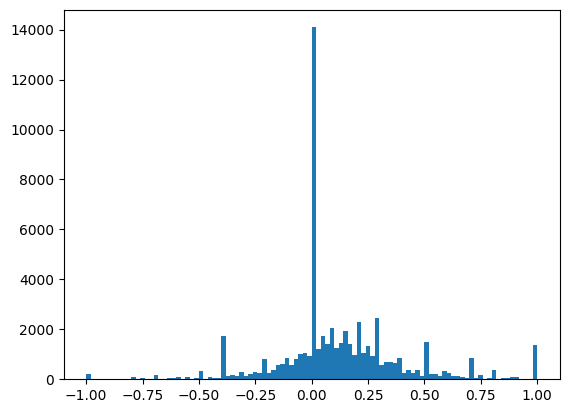

In [44]:
plt.hist(df_user_reviews['polarity'], bins=100)

In [45]:
df_user_reviews['sentiment_analysis'] = df_user_reviews['polarity'].apply(lambda x: 0 if x < 0 else (1 if x == 0 else 2))

In [46]:
df_user_reviews.columns

Index(['user_id', 'posted', 'item_id', 'recommend', 'review', 'polarity',
       'sentiment_analysis'],
      dtype='object')

In [47]:
df_user_reviews.drop(['review','polarity'], axis=1, inplace=True)

In [48]:
#no es necesario, es para poner la fecha pero no se usa
df_user_reviews['date'] = df_user_reviews['posted'].str.extract(r'(\w+\s\d+(?:,\s\d{4})?)')
df_user_reviews['date'] = pd.to_datetime(df_user_reviews['date'], format='%B %d, %Y', errors='coerce')

In [49]:
df_user_reviews['year'] = df_user_reviews['date'].dt.year

In [50]:
# Convertir los NaN a 0 en la columna 'year'
df_user_reviews['year'] = df_user_reviews['year'].fillna(0)

# Convertir la columna 'year' a tipo entero
df_user_reviews['year'] = df_user_reviews['year'].astype(int)

**tengo que ver que hago con los que no tienen año**

In [51]:
df_user_reviews.reset_index()

,index,user_id,posted,item_id,recommend,sentiment_analysis,date,year
0,0,76561197970982479,"Posted November 5, 2011.",1250,True,2,2011-11-05,2011
1,0,76561197970982479,"Posted July 15, 2011.",22200,True,2,2011-07-15,2011
2,0,76561197970982479,"Posted April 21, 2011.",43110,True,2,2011-04-21,2011
3,1,js41637,"Posted June 24, 2014.",251610,True,2,2014-06-24,2014
4,1,js41637,"Posted September 8, 2013.",227300,True,0,2013-09-08,2013
...,...,...,...,...,...,...,...,...
59328,25797,76561198312638244,Posted July 10.,70,True,2,NaT,0
59329,25797,76561198312638244,Posted July 8.,362890,True,2,NaT,0
59330,25798,LydiaMorley,Posted July 3.,273110,True,2,NaT,0
59331,25798,LydiaMorley,Posted July 20.,730,True,2,NaT,0


In [54]:
#dado que el ultimo año de las reseñas que tienen fecha es el 2015, parece que fueron realizadas en el año 2016,
# y cuando se realizaban en ese año no se ponía la fecha. Por eso relleno el valor de los años de reseña faltante 
# con el mayor entre ese año, y el año en que se lanzó el juego
df_steamgames.reset_index()

# Definir una función personalizada para aplicar la lógica deseada
def fill_year(row):
    if row['year'] == 0:
        # Obtener las filas de df_steamgames que cumplen con la condición
        steamgame_rows = df_steamgames[df_steamgames['id'] == row['item_id']]
        
        if not steamgame_rows.empty:
            # Si se encontraron filas, obtener el año de la primera fila y verificar si es mayor a 2016
            release_year = steamgame_rows['release_year'].iloc[0]
            return max(release_year, 2016)
        else:
            # Si no se encontraron filas, retornar 2016
            return 2016
    else:
        return row['year']

# Aplicar la función personalizada a la columna 'year' utilizando apply
df_user_reviews['year'] = df_user_reviews.apply(fill_year, axis=1)

# Convertir la columna 'year' a tipo entero
df_user_reviews['year'] = df_user_reviews['year'].astype(int)

In [55]:
#Agrupo lo que me sirve
df_user_item_played_year = df_user_reviews.groupby(['item_id', 'user_id', 'year']).size().reset_index(name='count')
df_user_item_played_year.drop('count', axis=1, inplace=True)
df_user_item_played_year['item_id']=df_user_item_played_year['item_id'].astype(int)

### Combinaciones

#### df_genres_detail

In [57]:
#Agrego las horas totales de cada juego
#primero armo un dataframe que es la suma total de horas jugadas de cada juego
df_hoursxgame = df_users_items.groupby(by=['item_id', 'item_name'])['playtime_forever'].sum().reset_index()
#cambio el tipo de item_id a integer
df_hoursxgame['item_id']=df_hoursxgame['item_id'].astype(int)
#agrego las horas al dataframe de steamgames
df_steamgames = df_steamgames.merge(df_hoursxgame[['item_id', 'playtime_forever']], on='item_id', how='left')

In [59]:
#genero una lista, que luego paso a dataframe, en la que busco el año con el maximo de horas jugadas
genres_RY_list=[]
#voy iterando por cada género
for i in genres:
    # genero un dataframe con cada año de lanzamiento y las horas jugadas, un agrupado del dataframe steamgames
    df_append = df_steamgames[df_steamgames[i] == 1].groupby(by=['release_year'])['playtime_forever'].sum().reset_index()
    # Encuentro el año con la máxima cantidad de horas jugadas
    max_hours_year = df_append.loc[df_append['playtime_forever'].idxmax(), 'release_year']
    # Agrego los datos a la lista de géneros y años de máximas horas jugadas
    genres_RY_list.append({'Genre': i, 'RYMaxHours': max_hours_year})
df_genres=pd.DataFrame(genres_RY_list)
df_genres['Genre']=df_genres['Genre'].astype(str)

In [60]:
#cambio el tipo de valor de item id
df_users_items['item_id']=df_users_items['item_id'].astype(int)
#Incluyo los generos en el dataframe de los usuarios
df_users_items = df_users_items.merge(df_steamgames, on='item_id', how='left')
#cambio nomnbre y elimino columnas duplicadas
df_users_items.rename(columns={'playtime_forever_x':'playtime_forever'}, inplace=True)
df_users_items.drop('playtime_forever_y', axis=1, inplace=True)
#convierto a enteros las columnas de generos para que ocupe menos memoria
for i in genres:
    df_users_items[i] = df_users_items[i].fillna(0).astype(int)

C:\Users\feder\AppData\Local\Temp\ipykernel_12140\1684202205.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_items['item_id']=df_users_items['item_id'].astype(int)


In [61]:
## JUGADOR QUE MAS HORAS JUGO

#genero una lista, que luego paso a dataframe, en la que busco el jugador con el maximo de horas jugadas
genres_MaxPlayer_list=[]
#voy iterando por cada género
for index, row in df_genres.iterrows():
    genero = row['Genre']
    # genero un dataframe con cada jugador y las horas jugadas de ese genero, un agrupado del dataframe df_users_items
    df_append = df_users_items[df_users_items[genero] == 1].groupby(by=['user_id'])['playtime_forever'].sum().reset_index()
    if not df_append.empty:
        # Encontrar el jugador con la máxima cantidad de horas jugadas
        max_hours_player = df_append.loc[df_append['playtime_forever'].idxmax(), 'user_id']
    else:
    # Manejar el caso en que la Serie esté vacía
        max_hours_player= 'Player Not Found'
    df_genres.at[index, 'PlayerMH'] = max_hours_player


In [62]:
## AÑO JUGADOR POR CADA JUGADOR

#primero debemos incluir el año en que jugó en una columna de users_items
df_users_items=df_users_items.merge(df_user_item_played_year, on=['item_id','user_id'],how='left')

# Itero sobre las filas de df_genresplayer
for index, row in df_genres.iterrows():
    genero = row['Genre']
    jugador = row['PlayerMH']
    
    # Filtro df_users_items para obtener las horas jugadas del jugador por género y año
    df_append_player = df_users_items[(df_users_items[genero] == 1) & (df_users_items['user_id'] == jugador)].groupby(by=['year'])['playtime_forever'].sum().reset_index()
    df_append_player = df_append_player.sort_values(by='playtime_forever', ascending=False)
    
    # Obtengo los años jugados y horas jugadas
    years_by_player = []
    for j in range(min(3, len(df_append_player))):
        this_year = '{Año: ' + str(int(df_append_player['year'].iloc[j])) + ', Horas: ' + str(int(df_append_player['playtime_forever'].iloc[j])) + '}'
        years_by_player.append(this_year)
    years_by_player=str(years_by_player)

    # Asigno la lista de años jugados y horas jugadas a la columna 'Years Played' en la fila actual
    df_genres.at[index, 'Years Played by player'] = years_by_player
    

In [64]:
df_genres.to_csv('Datos_procesados/genres_analysis.csv')

#### df_year_detail

In [ ]:
'''
Devuelve el top 3 de juegos MÁS recomendados por usuarios para el año dado. 
(reviews.recommend = True y comentarios positivos/neutrales)
Ejemplo de retorno: [{"Puesto 1" : X}, {"Puesto 2" : Y},{"Puesto 3" : Z}]

Devuelve el top 3 de juegos MENOS recomendados por usuarios para el año dado. 
(reviews.recommend = False y comentarios negativos)
Ejemplo de retorno: [{"Puesto 1" : X}, {"Puesto 2" : Y},{"Puesto 3" : Z}]

Según el año de lanzamiento, se devuelve una lista con la cantidad de registros de reseñas de usuarios 
que se encuentren categorizados con un análisis de sentimiento.
# Ejemplo de retorno: {Negative = 182, Neutral = 120, Positive = 278} 

'''

# Load

### UsersRecommend

### UsersNotRecommend

In [ ]:
''' '''

def UsersNotRecommend( año : int ):

### sentiment_analysis

In [ ]:
''' '''

def sentiment_analysis( año : int ):

# EDA

# ML

In [ ]:
'''Si es un sistema de recomendación item-item:
Ingresando el id de producto, deberíamos recibir una lista con 5 juegos recomendados similares al ingresado.'''

def recomendacion_juego( id de producto ):

In [ ]:
'''Si es un sistema de recomendación user-item:
 Ingresando el id de un usuario, deberíamos recibir una lista con 5 juegos recomendados para dicho usuario.
'''

def recomendacion_usuario( id de usuario ):